In [14]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocossessing

## Dataset

In [13]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"
print(coco_path)

/Users/mikey/.fastai/data/coco_sample/train_sample


In [19]:

paths = glob.glob(coco_path + "/*.jpg") # Grabbing all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 10_000, replace=False) # choosing 1000 images randomly
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:8000] # choosing the first 8000 as training set
val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

8000 2000


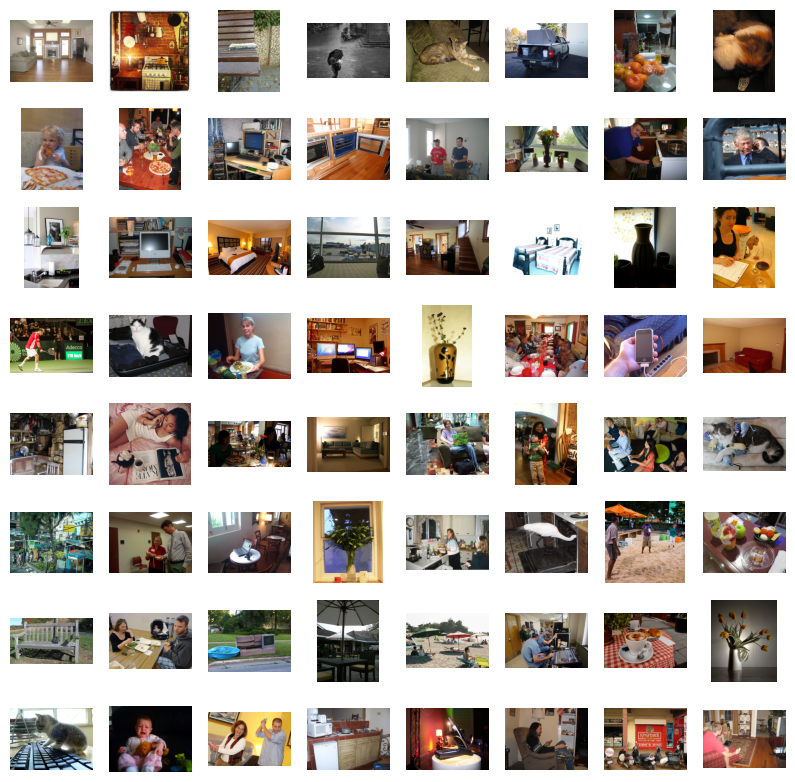

In [20]:
_, axes = plt.subplots(8, 8, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

**Custom PyTorch Dataset**

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, img_paths, resize=256, train=True ):
        self.img_paths = img_paths
        self.resize = resize
        if train == True:
            self.split = 'Train'
            self.transform = transforms.Resize((self.resize, self.resize),  Image.BICUBIC)
        else:
            self.split = 'Val'
            self.transform = transforms.Resize((self.resize, self.resize),  Image.BICUBIC)

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        trans_img = self.transform(img)
        img_lab = rgb2lab(np.array(trans_img)).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1



        return L, ab

## Dataloader

# GAN Architecture

## Generator

### UNET
* **Input**: 1x256x256 grayscale image. L from [L * a * b] colorspace.  
* **Output**: 3X256x26 in [L * a * b]  

In [9]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Downsampling layers
        self.down1 = nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)
        self.down2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.down3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.down4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.down5 = nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1)

        # Upsampling layers
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.up5 = nn.ConvTranspose2d(64, 2, kernel_size=4, stride=2, padding=1)

        # Activation functions and batch norm
        self.relu = nn.ReLU(True)
        self.leaky_relu = nn.LeakyReLU(0.2, True)
        self.batchnorm64 = nn.BatchNorm2d(64)
        self.batchnorm128 = nn.BatchNorm2d(128)
        self.batchnorm256 = nn.BatchNorm2d(256)
        self.batchnorm512 = nn.BatchNorm2d(512)

    def forward(self, x):
        # Downsample
        d1 = self.leaky_relu(self.batchnorm64(self.down1(x)))
        d2 = self.leaky_relu(self.batchnorm128(self.down2(d1)))
        d3 = self.leaky_relu(self.batchnorm256(self.down3(d2)))
        d4 = self.leaky_relu(self.batchnorm512(self.down4(d3)))
        d5 = self.leaky_relu(self.down5(d4))  # bottleneck

        # Upsample
        u1 = self.relu(self.up1(d5))
        u2 = self.relu(self.batchnorm256(self.up2(u1 + d4)))  # skip connection
        u3 = self.relu(self.batchnorm128(self.up3(u2 + d3)))  # skip connection
        u4 = self.relu(self.batchnorm64(self.up4(u3 + d2)))  # skip connection
        u5 = torch.tanh(self.up5(u4 + d1))  # skip connection

        return u5

### Test Model Output

In [10]:
#test the shape of model output
generator = UNet()
dummy_input = torch.randn([4, 1, 256, 256]) # batch_size, channels, size, size
out = generator(dummy_input)
out.shape

torch.Size([4, 3, 256, 256])

# Discriminator

In [ ]:

class Descriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 4, stride = 2)
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 4, stride = 2)
        self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 4, stride = 2)
        self.conv4 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 4, stride = 2)
        self.conv5 = nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 4, stride = 2)
        self.conv6 = nn.Conv2d(in_channels = 1024, out_channels = 1, kernel_size = 4, stride = 1)

        self.batchnorm64 = nn.BatchNorm2d(64)
        self.batchnorm128 = nn.BatchNorm2d(128)
        self.batchnorm256 = nn.BatchNorm2d(256)
        self.batchnorm512 = nn.BatchNorm2d(512)
        self.batchnorm1024 = nn.BatchNorm2d(1024)

        self.leaky_relu = nn.LeakyReLU(0.2, True)

    def forward(self, x):
        x = self.leaky_relu(self.batchnorm64(self.conv1(x)))
        x = self.leaky_relu(self.batchnorm128(self.conv2(x)))
        x = self.leaky_relu(self.batchnorm256(self.conv3(x)))
        x = self.leaky_relu(self.batchnorm512(self.conv4(x)))
        x = self.leaky_relu(self.batchnorm1024(self.conv5(x)))
        x = self.conv6(x)

        return torch.sigmoid(x)


# Training

## Hyperparameters

In [ ]:
# Assuming UNet is already defined as per the code above
generator = UNet()
discriminator = Discriminator()

# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

# Loss functions
adversarial_loss = nn.BCELoss()  
l1_loss = nn.L1Loss()

# Optimizers
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

# training params
epochs = 200
batch_size = 16

## Training Loop

In [ ]:
## THis is an example for referrence, NOT designed with our GAN in mind

for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):  # Replace 'dataloader' with your dataset's DataLoader
        
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Adversarial ground truths
        valid = torch.ones((batch_size, 1), requires_grad=False).to(device)
        fake = torch.zeros((batch_size, 1), requires_grad=False).to(device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Generate images with U-Net
        #z = torch.randn(batch_size, 1, 256, 256).to(device)  # Input noise or image

        generated_images = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(generated_images), valid)
        
        # Optional L1 loss for better image quality
        l1 = l1_loss(generated_images, real_images)
        g_total_loss = g_loss + 100 * l1  # Lambda for L1 loss weight

        g_total_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        real_loss = adversarial_loss(discriminator(real_images), valid)

        # Loss for fake images (generated by the generator)
        fake_loss = adversarial_loss(discriminator(generated_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # Print the progress
        print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_total_loss.item()}]")

In [ ]:
class GAN_train():
    def __init__(self):
        self.adversarial_loss
        if gen_loss == 'L1':
            self.generator_loss = nn.L1Loss
        else:
            self.generator_loss = PerceptualLoss()